In [38]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
from sklearn.datasets import make_regression, make_classification
import copy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import tqdm
%matplotlib inline

# ML/DL with Torch

For the whole tutorial, we will reuse the same "pipeline":
* Meet the Data
* Identify the task
* Choose a Model
* Choose a Loss
* Train
* Iterate until you have some results.

## Regression - Ordinary Least Square

#### Meet the Data

This is the right moment to think about splits (train, validation, test).

We will only separate the data on a train and a validation set here.

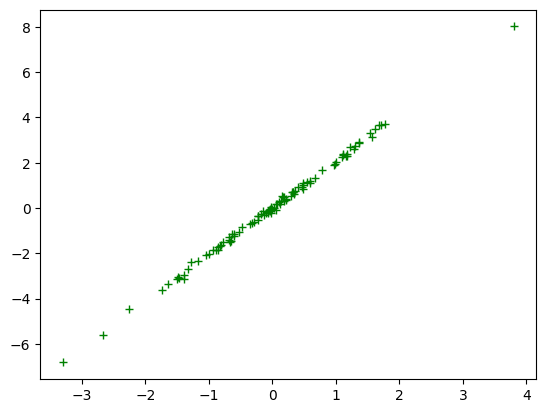

In [39]:
X, y = make_regression(
    n_samples=100, n_features=1, noise=4.0, bias=1
)
y/=40
y=y.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.plot(X, y, "g+", label="data")
plt.show()

#### What could be the task here?

Regression

#### What model could we use?

Well, it looks like something that is somewhat linear. A linear regressor should be alright then.

Here, the ordinary least square should be enough (the noise seems to be centered and "Gaussian"). 
In other words, we will minimize the MSE between the estimator and the real data, by affecting the parameters of the model.

This problem can be solved analytically, but we will use an explicit numerical optimization to show the general process of most, if not all, machine learning methods.

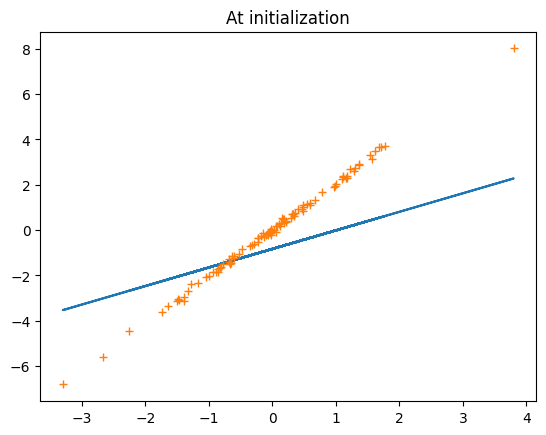

In [40]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear=nn.Linear(input_size, output_size, bias=True)
    def forward(self, x):
        return self.linear(x)
    
#instantiate the model object
input_dim=1
output_dim=1
model=LinearRegressionModel(input_dim, output_dim)
#instantiate loss
criterion=nn.MSELoss(reduction="mean")
output_=model(torch.from_numpy(X).float())
plt.figure()
plt.plot(X, output_.data,"-")
plt.plot(X, y,"+")
plt.title("At initialization")
plt.show()

#### Training

Training is just a fancy word to say optimization/minimization.

In this case, we want to minimize the MSE between the real data and the estimation.

100%|██████████| 100/100 [00:00<00:00, 513.71Epochs/s, loss_=0.009415443]


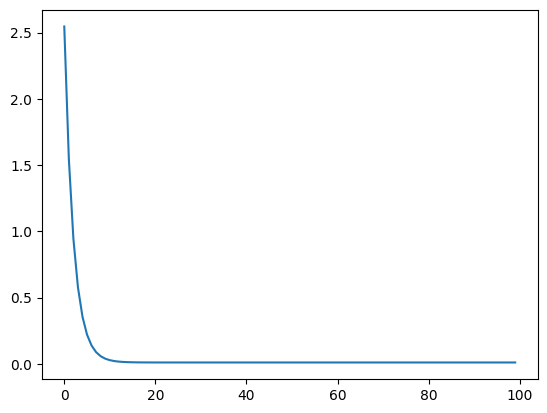

In [41]:

# instantiate optimizer class
learning_rate=0.1
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs=100
loss_array = []

with tqdm.trange(epochs, unit="Epochs") as pbar:
    for epoch in pbar:
        epoch+=1
        #convert numpy array to torch Variable
        inputs=Variable(torch.from_numpy(X_train))
        labels=Variable(torch.from_numpy(y_train))
        #clear gradients wrt. parameters
        optimizer.zero_grad()

        #Forward to get outputs
        outputs=model(inputs.float())
        #calculate loss
        loss=criterion(outputs.float(), labels.float())

        #getting gradients wrt parameters
        loss.backward()
        #updating parameters
        optimizer.step()
        loss_array.append(loss.data)
        pbar.set_postfix(loss_=loss.data.detach().numpy())


    #print(f'epoch {epoch}, loss {loss.data}')
plt.figure()
plt.plot(loss_array)
plt.show()

In [42]:
regr = LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
param_list = list(model.parameters())
print(f"Sklearn says: {regr.coef_[0,0]:.4f}x + {regr.intercept_[0]:.4f}")
print(f"PyTorch says: {model.linear.weight.detach().numpy()[0,0]:.4f}x + {model.linear.bias.detach().numpy()[0]:.4f}")

Sklearn says: 2.0757x + 0.0177
PyTorch says: 2.0757x + 0.0177


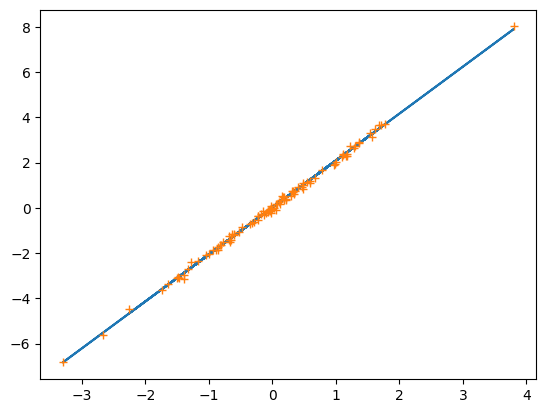

In [43]:
output_=model(torch.from_numpy(X).float())
plt.figure()
plt.plot(X, output_.data,"-")
plt.plot(X, y,"+")
plt.show()

## Regression - Ridge Regression

There is not much to change here.

But we need to add a regularization term....

Well PyTorch can do that for us with the '''weight_decay''' in the optimizer. This does the L2 regularization under the hood.
But we might as well write it down.

epoch 1, loss 5.262573719024658
epoch 2, loss 3.221498727798462
epoch 3, loss 2.0380706787109375
epoch 4, loss 1.3518249988555908
epoch 5, loss 0.9538293480873108
epoch 6, loss 0.7229711413383484
epoch 7, loss 0.5890382528305054
epoch 8, loss 0.5113219618797302
epoch 9, loss 0.4662163257598877
epoch 10, loss 0.44003161787986755
epoch 11, loss 0.4248267412185669
epoch 12, loss 0.4159950911998749
epoch 13, loss 0.4108636677265167
epoch 14, loss 0.40788114070892334
epoch 15, loss 0.4061468839645386
epoch 16, loss 0.4051381051540375
epoch 17, loss 0.4045509994029999
epoch 18, loss 0.40420910716056824
epoch 19, loss 0.4040099084377289
epoch 20, loss 0.4038937985897064
epoch 21, loss 0.4038260877132416
epoch 22, loss 0.4037865400314331
epoch 23, loss 0.40376341342926025
epoch 24, loss 0.40374988317489624
epoch 25, loss 0.4037419557571411
epoch 26, loss 0.403737336397171
epoch 27, loss 0.40373462438583374
epoch 28, loss 0.4037330150604248
epoch 29, loss 0.4037321209907532
epoch 30, loss 0.403

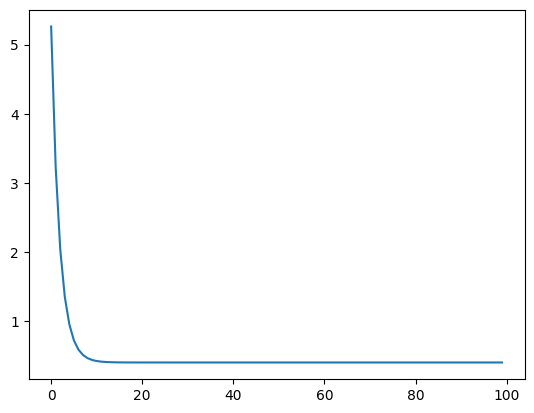

In [44]:
#instantiate the model object
input_dim=1
output_dim=1
ridge_model=LinearRegressionModel(input_dim, output_dim)
cloned_model=copy.deepcopy(ridge_model)
#instantiate loss
criterion=nn.MSELoss()
output_=ridge_model(torch.from_numpy(X).float())


# instantiate optimizer class
learning_rate=0.1
optimizer=torch.optim.SGD(ridge_model.parameters(), lr=learning_rate)
epochs=100
loss_array = []
alpha = 0.1
model
for epoch in range(epochs):
    epoch+=1
    #convert numpy array to torch Variable
    inputs=Variable(torch.from_numpy(X_train))
    labels=Variable(torch.from_numpy(y_train))
    #clear gradients wrt. parameters
    optimizer.zero_grad()

    #Forward to get outputs
    outputs=ridge_model(inputs.float())
    #calculate loss
    loss=criterion(outputs.float(), labels.float())
    # Calculating and adding the penalty
    l2_penalty = nn.MSELoss(reduction="sum")(ridge_model.linear.weight, torch.zeros_like(ridge_model.linear.weight))
    loss += alpha * l2_penalty
    #getting gradients wrt parameters
    loss.backward()
    #updating parameters
    optimizer.step()
    loss_array.append(loss.data)
    print(f'epoch {epoch}, loss {loss.data}')
plt.plot(loss_array)

epoch 1, loss 5.261551856994629
epoch 2, loss 3.1648356914520264
epoch 3, loss 2.0436301231384277
epoch 4, loss 1.4218143224716187
epoch 5, loss 1.0638412237167358
epoch 6, loss 0.8503013849258423
epoch 7, loss 0.7188307046890259
epoch 8, loss 0.6357221603393555
epoch 9, loss 0.5820731520652771
epoch 10, loss 0.5468835830688477
epoch 11, loss 0.5235282778739929
epoch 12, loss 0.5078942775726318
epoch 13, loss 0.49736490845680237
epoch 14, loss 0.4902428984642029
epoch 15, loss 0.48541101813316345
epoch 16, loss 0.48212558031082153
epoch 17, loss 0.47988826036453247
epoch 18, loss 0.4783629775047302
epoch 19, loss 0.47732219099998474
epoch 20, loss 0.4766116142272949
epoch 21, loss 0.4761263430118561
epoch 22, loss 0.47579464316368103
epoch 23, loss 0.4755679666996002
epoch 24, loss 0.47541290521621704
epoch 25, loss 0.47530683875083923
epoch 26, loss 0.47523412108421326
epoch 27, loss 0.47518450021743774
epoch 28, loss 0.47515052556991577
epoch 29, loss 0.47512727975845337
epoch 30, lo

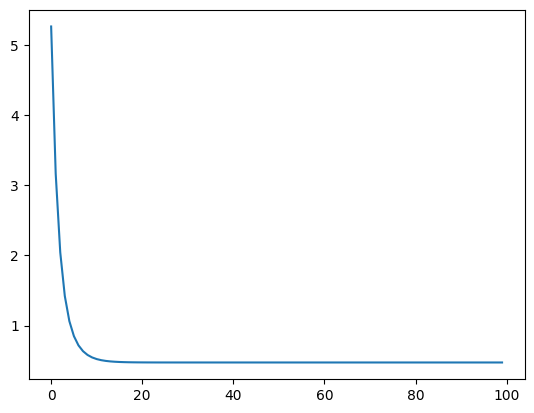

In [45]:
#instantiate the model object
input_dim=1
output_dim=1
ridge_model=cloned_model
#instantiate loss
criterion=nn.MSELoss()
output_=ridge_model(torch.from_numpy(X).float())


# instantiate optimizer class
learning_rate=0.1
optimizer=torch.optim.SGD(ridge_model.parameters(), lr=learning_rate, weight_decay=1)
epochs=100
loss_array = []
alpha = 1
model
for epoch in range(epochs):
    epoch+=1
    #convert numpy array to torch Variable
    inputs=Variable(torch.from_numpy(X_train))
    labels=Variable(torch.from_numpy(y_train))
    #clear gradients wrt. parameters
    optimizer.zero_grad()

    #Forward to get outputs
    outputs=ridge_model(inputs.float())
    #calculate loss
    loss=criterion(outputs.float(), labels.float())
    #getting gradients wrt parameters
    loss.backward()
    #updating parameters
    optimizer.step()
    loss_array.append(loss.data)
    print(f'epoch {epoch}, loss {loss.data}')
plt.plot(loss_array)

#### Possible Improvements

There is a lot of replicated code here: refactoring it by using a ```train_epoch``` function could be a great way to make the code more modular!

Your turn to work then.

## Logistic Regression

#### Meet the Data

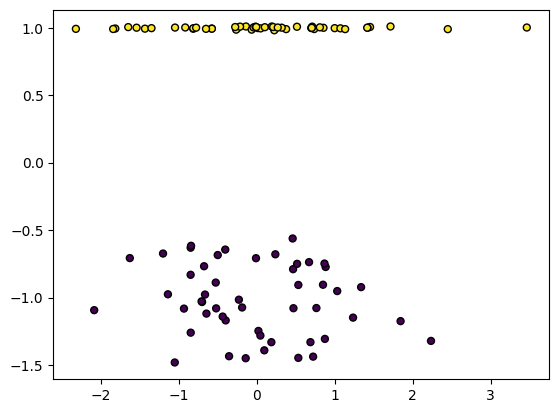

In [46]:
X1, Y1 = make_classification(
    n_features=2, n_redundant=0, n_informative=1, n_clusters_per_class=1
)
Y1 = Y1.reshape(-1,1)
plt.scatter(X1[:, 0], X1[:, 1], marker="o", c=Y1, s=25, edgecolor="k")
X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)
plt.show()

It looks a lot like a classification task between the purple and the yellow, on a 2D plane.

Well, we can use the logistic regression for this!

In this case, the loss function is the **binary cross-entropy**, and we introduce a non-linearity: the sigmoid.

In [47]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size=1):
        super(LogisticRegressionModel, self).__init__()
        self.linear=nn.Linear(input_size, output_size, bias=True)
    def forward(self, x):
        return torch.sigmoid(self.linear(x)) # non-linearity here.

#### Practice time!

100%|██████████| 1000/1000 [00:04<00:00, 234.17Epochs/s, train_acc=1, val_acc=1]      


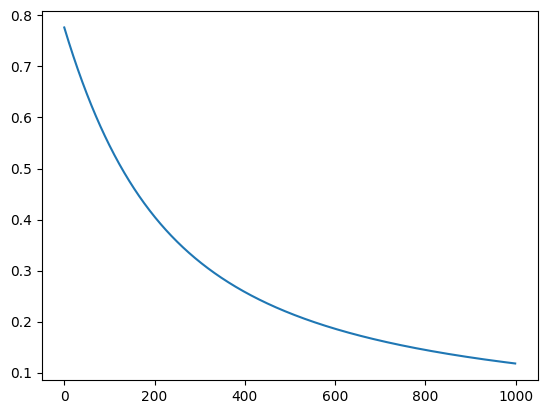

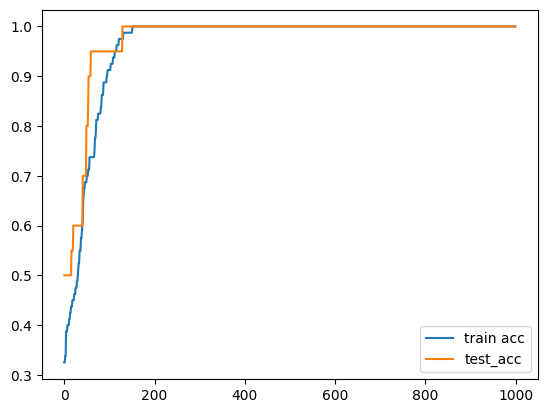

In [48]:
#instantiate the model object
input_dim=1
output_dim=1
logistic_model=LogisticRegressionModel(2,1)
#instantiate loss
criterion=nn.BCELoss()
output_=logistic_model(torch.from_numpy(X1).float())


# instantiate optimizer class
learning_rate=0.01
optimizer=torch.optim.SGD(logistic_model.parameters(), lr=learning_rate, weight_decay=0)
epochs=1000
loss_array = []
accuracy_array = []

alpha = 1
model
with tqdm.trange(epochs, unit="Epochs") as pbar:
    for epoch in pbar:
        epoch+=1
        #convert numpy array to torch Variable
        inputs=Variable(torch.from_numpy(X_train))
        labels=Variable(torch.from_numpy(y_train))
        #clear gradients wrt. parameters
        optimizer.zero_grad()

        #Forward to get outputs
        outputs=logistic_model(inputs.float())
        #calculate loss
        loss=criterion(outputs.float(), labels.float())
        #getting gradients wrt parameters
        loss.backward()
        #updating parameters
        optimizer.step()
        loss_array.append(loss.data)
        y_pred=logistic_model(torch.from_numpy(X_test).float()).detach().numpy()>=0.5
        y_train_pred = logistic_model(torch.from_numpy(X_train).float()).detach().numpy()>=0.5
        train_acc, test_acc = accuracy_score(y_train, y_train_pred),accuracy_score(y_test, y_pred)
        accuracy_array.append([train_acc, test_acc])
        pbar.set_postfix(train_acc=train_acc,val_acc=test_acc)
        #print(f'epoch {epoch}, loss {loss.data}')
plt.figure()
plt.plot(loss_array)

plt.figure()
acc_array = np.array(accuracy_array)
plt.plot(acc_array[:,0].T,label="train acc")
plt.plot(acc_array[:,1].T, label ="test_acc")
plt.legend()
plt.show()

In [49]:
y_pred=logistic_model(torch.from_numpy(X_test).float()).detach().numpy()>=0.5
y_train_pred = logistic_model(torch.from_numpy(X_train).float()).detach().numpy()>=0.5
print(f"accuracy on training set {accuracy_score(y_train, y_train_pred)}")
print(f"accuracy on test set {accuracy_score(y_test, y_pred)}")

accuracy on training set 1.0
accuracy on test set 1.0


## Overfitting and Underfitting

Let's say we want to estimate the function x*sin(x)

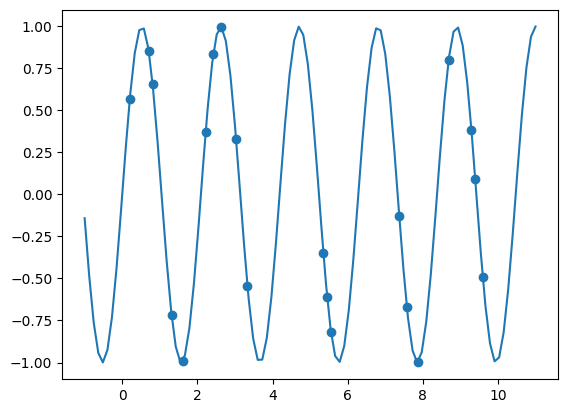

In [50]:
def f(x):
    return np.sin(3*x)


# whole range we want to plot
x_plot = np.linspace(-1, 11, 100)
x_train = np.linspace(0, 10, 100)
rng = np.random.RandomState(0)
x_train = np.sort(rng.choice(x_train, size=20, replace=False)).reshape(-1,1)
y_train = f(x_train).reshape(-1,1)


# create 2D-array versions of these arrays to feed to transformers
X_train = x_train[:, np.newaxis]
X_plot = x_plot[:, np.newaxis]
fig, ax = plt.subplots()
ax.plot(x_plot, f(x_plot))
ax.scatter(x_train, y_train, label="training points")
plt.show()

epoch 1, loss 14.759562492370605
epoch 2, loss 2.151674747467041
epoch 3, loss 0.7157654166221619
epoch 4, loss 0.5510729551315308
epoch 5, loss 0.5310415625572205
epoch 6, loss 0.5274862051010132
epoch 7, loss 0.5258210301399231
epoch 8, loss 0.5243862867355347
epoch 9, loss 0.5229930877685547
epoch 10, loss 0.5216196179389954
epoch 11, loss 0.520263135433197
epoch 12, loss 0.5189233422279358
epoch 13, loss 0.5175997614860535
epoch 14, loss 0.5162924528121948
epoch 15, loss 0.5150010585784912
epoch 16, loss 0.5137253999710083
epoch 17, loss 0.5124653577804565
epoch 18, loss 0.5112206339836121
epoch 19, loss 0.5099911093711853
epoch 20, loss 0.5087766647338867
epoch 21, loss 0.5075770020484924
epoch 22, loss 0.5063919425010681
epoch 23, loss 0.505221426486969
epoch 24, loss 0.5040650963783264
epoch 25, loss 0.5029229521751404
epoch 26, loss 0.501794695854187
epoch 27, loss 0.5006802678108215
epoch 28, loss 0.49957942962646484
epoch 29, loss 0.49849194288253784
epoch 30, loss 0.49741783

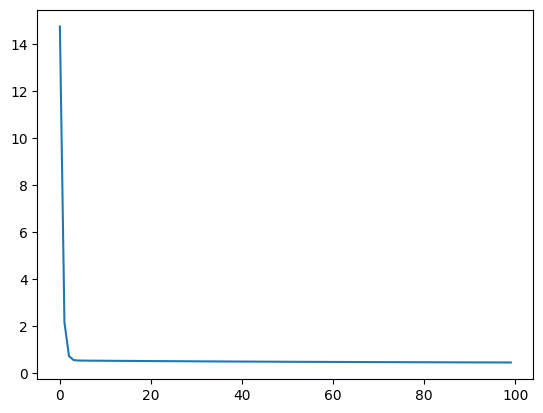

In [51]:
X_train=x_train
#instantiate the model object
input_dim=1
output_dim=1
model=LinearRegressionModel(input_dim, output_dim)
#instantiate loss
criterion=nn.MSELoss(reduction="mean")
# instantiate optimizer class
learning_rate=0.01
optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs=100
loss_array = []
for epoch in range(epochs):
    epoch+=1
    #convert numpy array to torch Variable
    inputs=Variable(torch.from_numpy(X_train))
    labels=Variable(torch.from_numpy(y_train))
    #clear gradients wrt. parameters
    optimizer.zero_grad()

    #Forward to get outputs
    outputs=model(inputs.float())
    #calculate loss
    loss=criterion(outputs.float(), labels.float())

    #getting gradients wrt parameters
    loss.backward()
    #updating parameters
    optimizer.step()
    loss_array.append(loss.data)


    print(f'epoch {epoch}, loss {loss.data}')

plt.plot(loss_array)
out_linear = model(torch.from_numpy(x_plot.reshape(-1,1)).float()).detach().numpy()


In [52]:
   

MLP = nn.Sequential(
    nn.Linear(1, 50),
    nn.LeakyReLU(),
    nn.Linear(50, 50),
    nn.LeakyReLU(),
    nn.Linear(50, 50),
    nn.LeakyReLU(),
    nn.Linear(50, 50),
    nn.LeakyReLU(),
    nn.Linear(50, 1),
)

epoch 1, loss 0.4516916871070862
epoch 2, loss 0.446073442697525
epoch 3, loss 0.4423213601112366
epoch 4, loss 0.43869084119796753
epoch 5, loss 0.4353770315647125
epoch 6, loss 0.43266168236732483
epoch 7, loss 0.43026357889175415
epoch 8, loss 0.42766231298446655
epoch 9, loss 0.4249952733516693
epoch 10, loss 0.4225533604621887
epoch 11, loss 0.42028480768203735
epoch 12, loss 0.4180445671081543
epoch 13, loss 0.41605257987976074
epoch 14, loss 0.4137711524963379
epoch 15, loss 0.41149598360061646
epoch 16, loss 0.4098256230354309
epoch 17, loss 0.40753093361854553
epoch 18, loss 0.40556567907333374
epoch 19, loss 0.4038577079772949
epoch 20, loss 0.4021069407463074
epoch 21, loss 0.400535523891449
epoch 22, loss 0.3984610140323639
epoch 23, loss 0.39660027623176575
epoch 24, loss 0.39497488737106323
epoch 25, loss 0.3935171663761139
epoch 26, loss 0.39144763350486755
epoch 27, loss 0.3894501328468323
epoch 28, loss 0.3876153826713562
epoch 29, loss 0.385807603597641
epoch 30, loss

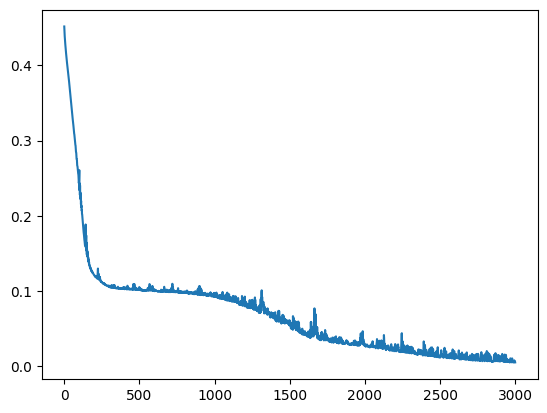

In [53]:
X_train=x_train
#instantiate the model object
input_dim=1
output_dim=1
model=MLP
#instantiate loss
criterion=nn.MSELoss(reduction="mean")
# instantiate optimizer class
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs=3000
loss_array = []
for epoch in range(epochs):
    epoch+=1
    #convert numpy array to torch Variable
    inputs=Variable(torch.from_numpy(X_train))
    labels=Variable(torch.from_numpy(y_train))
    #clear gradients wrt. parameters
    optimizer.zero_grad()

    #Forward to get outputs
    outputs=model(inputs.float())
    #calculate loss
    loss=criterion(outputs.float(), labels.float())

    #getting gradients wrt parameters
    loss.backward()
    #updating parameters
    optimizer.step()
    loss_array.append(loss.data)


    print(f'epoch {epoch}, loss {loss.data}')

plt.plot(loss_array)
out_mlp = model(torch.from_numpy(x_plot.reshape(-1,1)).float()).detach().numpy()

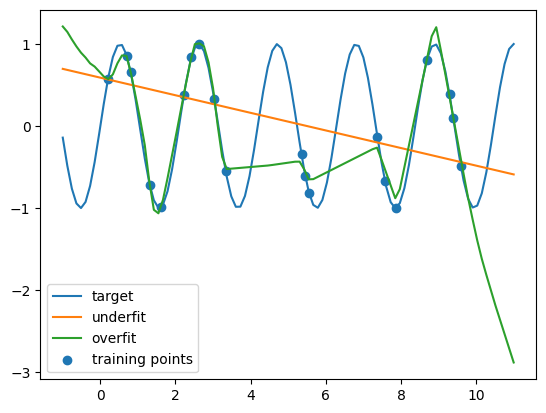

In [54]:
fig, ax = plt.subplots()
ax.plot(x_plot, f(x_plot),label="target")
ax.plot(x_plot, out_linear, label="underfit")
ax.plot(x_plot, out_mlp, label="overfit")
ax.scatter(x_train, y_train, label="training points")
plt.legend()